# Regression Analysis Notebook

This notebook will explore how renewable energy adoption, energy efficiency, and emissions explain or predict **sectoral economic growth** (Agriculture, Industry, Services) across income levels.

I will build regression models **per sector** and **per income level** using clean preprocessed data from `growth_rates_emissions_energy_prod_income_level_country_df.csv`.


In [60]:
# Import essential libraries
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import LeaveOneOut, cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns

from linearmodels.panel import PanelOLS, RandomEffects
from statsmodels.tools.tools import add_constant
import statsmodels.api as sm
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

In [61]:
# Load preprocessed dataset
growth_rates_emissions_energy_prod_income_level_country_df = pd.read_csv('../datasets/growth_rates_emissions_energy_prod_income_level_country_df.csv')

# Display basic info
growth_rates_emissions_energy_prod_income_level_country_df.head()


,Unnamed: 0,Country Name,Country Code,Series Name,Series Code,1989_1989,1990_1990,1991_1991,1992_1992,1993_1993,...,2015_2015,2016_2016,2017_2017,2018_2018,2019_2019,2020_2020,2021_2021,2022_2022,2023_2023,Income Level
0,0,Afghanistan,AFG,Access to clean fuels and technologies for coo...,EG.CFT.ACCS.ZS,21.708333,21.708333,21.708333,21.708333,21.708333,...,27.6,28.8,30.3,31.4,32.6,33.8,34.9,36.1,36.1,Low income
1,1,Afghanistan,AFG,Access to clean fuels and technologies for coo...,EG.CFT.ACCS.RU.ZS,8.479167,8.479167,8.479167,8.479167,8.479167,...,11.4,12.6,13.5,14.5,15.6,16.4,17.4,18.5,18.5,Low income
2,2,Afghanistan,AFG,Access to clean fuels and technologies for coo...,EG.CFT.ACCS.UR.ZS,66.031250,66.031250,66.031250,66.031250,66.031250,...,79.5,80.5,81.6,82.6,83.2,83.8,84.5,85.0,85.0,Low income
3,3,Afghanistan,AFG,Access to electricity (% of population),EG.ELC.ACCS.ZS,58.266667,58.266667,58.266667,58.266667,58.266667,...,71.5,97.7,97.7,93.4,97.7,97.7,97.7,85.3,85.3,Low income
4,4,Afghanistan,AFG,"Access to electricity, rural (% of rural popul...",EG.ELC.ACCS.RU.ZS,57.461905,57.461905,57.461905,57.461905,57.461905,...,64.6,97.1,97.1,91.6,97.1,97.1,97.1,81.7,81.7,Low income


### Panel regression

In [63]:
def prepare_panel_data(df, income_level, dependent_series):
    # Define core independent variables
    independent_vars = [
        'Renewable energy consumption (% of total final energy consumption)',
        'Energy intensity level of primary energy (MJ/$2017 PPP GDP)',
        'Access to electricity (% of population)',
        'GDP per unit of energy use (PPP $ per kg of oil equivalent)',
        'Carbon dioxide (CO2) emissions excluding LULUCF per capita (t CO2e/capita)'
    ]

    additional_vars = [
        'GDP growth (annual %)',
        'PM2.5 air pollution, mean annual exposure (micrograms per cubic meter)'
    ]
    all_required_series = [dependent_series] + independent_vars + additional_vars

    # Filter by income level
    df_filtered = df[df['Income Level'] == income_level].copy()

    # Filter for 2000–2023 only
    year_columns = [col for col in df_filtered.columns if col.startswith('20')]
    selected_columns = ['Country Name', 'Series Name'] + year_columns
    df_filtered = df_filtered[selected_columns]

    # Keep only required series
    df_filtered = df_filtered[df_filtered['Series Name'].isin(all_required_series)]

    # Melt to long format
    df_long = df_filtered.melt(
        id_vars=['Country Name', 'Series Name'],
        var_name='Year',
        value_name='Value'
    )

    # Pivot so each series becomes column
    df_pivot = df_long.pivot_table(
        index=['Country Name', 'Year'],
        columns='Series Name',
        values='Value'
    ).reset_index()

    # Rename and clean
    df_pivot.columns.name = None
    df_pivot.rename(columns={'Country Name': 'country', 'Year': 'year'}, inplace=True)

    # Drop rows with any NA
    df_panel = df_pivot.dropna()

    return df_panel


In [64]:
def run_panel_regression_with_hausman(df_panel, dependent_var):

    # Ensure year is int
    df_panel['year'] = df_panel['year'].astype(int)

    # Set panel structure
    df_panel.set_index(['country', 'year'], inplace=True)

    # Define independent variables
    independent_vars = [
        'Renewable energy consumption (% of total final energy consumption)',
        'Energy intensity level of primary energy (MJ/$2017 PPP GDP)',
        'Access to electricity (% of population)',
        'GDP per unit of energy use (PPP $ per kg of oil equivalent)',
        'Carbon dioxide (CO2) emissions excluding LULUCF per capita (t CO2e/capita)'
    ]

    if 'GDP growth (annual %)' in df_panel.columns:
        independent_vars.append('GDP growth (annual %)')
    if 'PM2.5 air pollution, mean annual exposure (micrograms per cubic meter)' in df_panel.columns:
        independent_vars.append('PM2.5 air pollution, mean annual exposure (micrograms per cubic meter)')
    if 'REC_GDPgrowth' in df_panel.columns:
        independent_vars.append('REC_GDPgrowth')
    
    # Drop NA
    df_model = df_panel[[dependent_var] + independent_vars].dropna()

    y_target = df_model[dependent_var]
    X_features = add_constant(df_model[independent_vars])

    # --- Fixed Effects Model ---
    fixed_effects_model = PanelOLS(y_target, X_features, entity_effects=True, time_effects=True)
    fixed_effects_results = fixed_effects_model.fit(cov_type='robust')

    # --- Random Effects Model ---
    random_effects_model = RandomEffects(y_target, X_features)
    random_effects_results = random_effects_model.fit(cov_type='robust')

    # --- Hausman Test ---
    beta_difference = fixed_effects_results.params - random_effects_results.params
    cov_difference = fixed_effects_results.cov - random_effects_results.cov
    hausman_statistic = beta_difference.T @ np.linalg.inv(cov_difference) @ beta_difference
    degrees_of_freedom = beta_difference.shape[0]
    hausman_p_value = 1 - stats.chi2.cdf(hausman_statistic, degrees_of_freedom)

    recommended_model = 'Fixed Effects' if hausman_p_value < 0.05 else 'Random Effects'

    # Print results
    print(f"--- Hausman Test ---\nStatistic: {hausman_statistic:.4f}, p-value: {hausman_p_value:.4f}")
    print(f"Recommended model: {recommended_model}\n")

    print("--- Fixed Effects Results ---")
    print(fixed_effects_results.summary)

    print("\n--- Random Effects Results ---")
    print(random_effects_results.summary)

    return {
        'hausman_stat': hausman_statistic,
        'hausman_pval': hausman_p_value,
        'recommended_model': recommended_model,
        'fe_results': fixed_effects_results,
        're_results': random_effects_results
    }


#### Agriculture

In [66]:
agri_df_low = prepare_panel_data(
    df=growth_rates_emissions_energy_prod_income_level_country_df,
    income_level='Low income',
    dependent_series='Agriculture, forestry, and fishing, value added (annual % growth)'
)
print(agri_df_low['country'].nunique())
agri_df_low = agri_df_low.reset_index()

agri_df_low['year'] = agri_df_low['year'].astype(str).str[:4].astype(int)

print(f'Shape of panel data(target: Agriculture, income level: Low):', agri_df_low.shape)

11
Shape of panel data(target: Agriculture, income level: Low): (264, 11)


#### Agriculture for low income

--- Hausman Test ---
Statistic: -1.8391, p-value: 1.0000
Recommended model: Random Effects

--- Fixed Effects Results ---
                                                  PanelOLS Estimation Summary                                                  
Dep. Variable:     Agriculture, forestry, and fishing, value added (annual % growth)   R-squared:                        0.2056
Estimator:                                                                  PanelOLS   R-squared (Between):             -33.488
No. Observations:                                                                264   R-squared (Within):               0.1691
Date:                                                               Wed, May 07 2025   R-squared (Overall):             -1.2913
Time:                                                                       15:03:19   Log-likelihood                   -939.21
Cov. Estimator:                                                               Robust                          

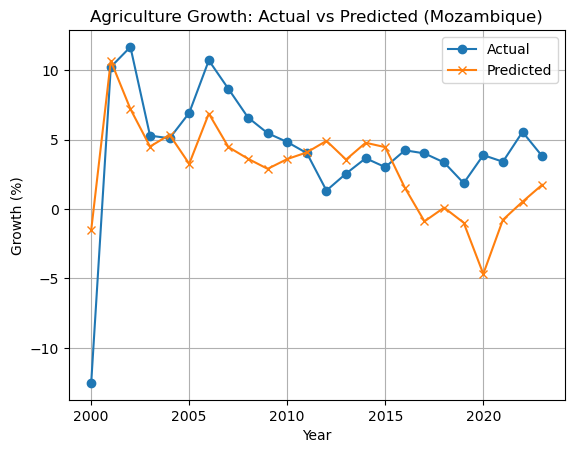

In [68]:
results_agri_low = run_panel_regression_with_hausman(
    df_panel=agri_df_low,
    dependent_var='Agriculture, forestry, and fishing, value added (annual % growth)'
)

# After fitting Random Effects model
y_pred = results_agri_low['re_results'].predict().fitted_values
agri_df_low = agri_df_low.reset_index()

# Add to original data to compare actual vs predicted
agri_df_low['actual'] = agri_df_low['Agriculture, forestry, and fishing, value added (annual % growth)']
agri_df_low['predicted'] = y_pred.values


sample_country = 'Mozambique'

df_sample = agri_df_low[agri_df_low['country'] == sample_country]

plt.plot(df_sample['year'], df_sample['actual'], label='Actual', marker='o')
plt.plot(df_sample['year'], df_sample['predicted'], label='Predicted', marker='x')
plt.title(f'Agriculture Growth: Actual vs Predicted ({sample_country})')
plt.xlabel('Year')
plt.ylabel('Growth (%)')
plt.legend()
plt.grid(True)
plt.show()

#### Agriculture for lower middle income

Shape of panel data(target: Agriculture, income level: Lower middle income): (1152, 10)
Columns of panel data(target: Agriculture, income level: Lower middle income): Index(['country', 'year', 'Access to electricity (% of population)',
       'Agriculture, forestry, and fishing, value added (annual % growth)',
       'Carbon dioxide (CO2) emissions excluding LULUCF per capita (t CO2e/capita)',
       'Energy intensity level of primary energy (MJ/$2017 PPP GDP)',
       'GDP growth (annual %)',
       'GDP per unit of energy use (PPP $ per kg of oil equivalent)',
       'PM2.5 air pollution, mean annual exposure (micrograms per cubic meter)',
       'Renewable energy consumption (% of total final energy consumption)'],
      dtype='object')
--- Hausman Test ---
Statistic: 6.6497, p-value: 0.5749
Recommended model: Random Effects

--- Fixed Effects Results ---
                                                  PanelOLS Estimation Summary                                                  
D

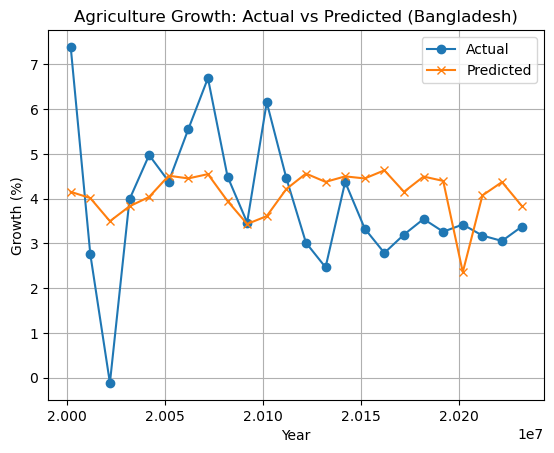

In [70]:
agri_df_lower_middle = prepare_panel_data(
    df=growth_rates_emissions_energy_prod_income_level_country_df,
    income_level='Lower middle income',
    dependent_series='Agriculture, forestry, and fishing, value added (annual % growth)'
)

print(f'Shape of panel data(target: Agriculture, income level: Lower middle income):', agri_df_lower_middle.shape)
print(f'Columns of panel data(target: Agriculture, income level: Lower middle income):', agri_df_lower_middle.columns)
results_agri_lower_middle = run_panel_regression_with_hausman(
    df_panel=agri_df_lower_middle,
    dependent_var='Agriculture, forestry, and fishing, value added (annual % growth)'
)
# After fitting Random Effects model
y_pred = results_agri_lower_middle['re_results'].predict().fitted_values
agri_df_lower_middle = agri_df_lower_middle.reset_index()

# Add to original data to compare actual vs predicted
agri_df_lower_middle['actual'] = agri_df_lower_middle['Agriculture, forestry, and fishing, value added (annual % growth)']
agri_df_lower_middle['predicted'] = y_pred.values

sample_country = 'Bangladesh'

df_sample = agri_df_lower_middle[agri_df_lower_middle['country'] == sample_country]

plt.plot(df_sample['year'], df_sample['actual'], label='Actual', marker='o')
plt.plot(df_sample['year'], df_sample['predicted'], label='Predicted', marker='x')
plt.title(f'Agriculture Growth: Actual vs Predicted ({sample_country})')
plt.xlabel('Year')
plt.ylabel('Growth (%)')
plt.legend()
plt.grid(True)
plt.show()


#### Agriculture for upper middle income

Shape of panel data(target: Agriculture, income level: Upper middle income): (1080, 10)
Columns of panel data(target: Agriculture, income level: Upper middle income): Index(['country', 'year', 'Access to electricity (% of population)',
       'Agriculture, forestry, and fishing, value added (annual % growth)',
       'Carbon dioxide (CO2) emissions excluding LULUCF per capita (t CO2e/capita)',
       'Energy intensity level of primary energy (MJ/$2017 PPP GDP)',
       'GDP growth (annual %)',
       'GDP per unit of energy use (PPP $ per kg of oil equivalent)',
       'PM2.5 air pollution, mean annual exposure (micrograms per cubic meter)',
       'Renewable energy consumption (% of total final energy consumption)'],
      dtype='object')
--- Hausman Test ---
Statistic: 5.1609, p-value: 0.7403
Recommended model: Random Effects

--- Fixed Effects Results ---
                                                  PanelOLS Estimation Summary                                                  
D

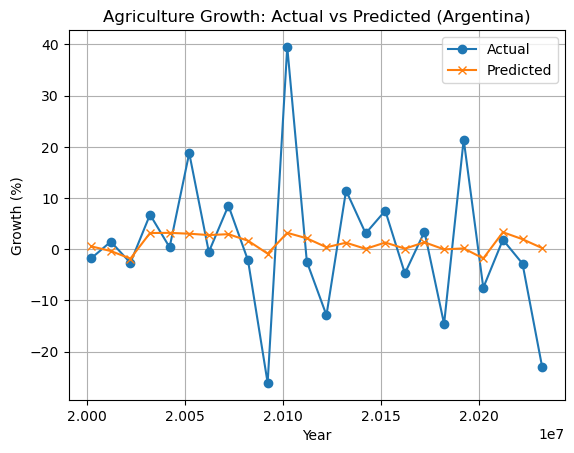

In [72]:
agri_df_upper_middle = prepare_panel_data(
    df=growth_rates_emissions_energy_prod_income_level_country_df,
    income_level='Upper middle income',
    dependent_series='Agriculture, forestry, and fishing, value added (annual % growth)'
)
print(f'Shape of panel data(target: Agriculture, income level: Upper middle income):', agri_df_upper_middle.shape)
print(f'Columns of panel data(target: Agriculture, income level: Upper middle income):', agri_df_upper_middle.columns)
results_agri_upper_middle = run_panel_regression_with_hausman(
    df_panel=agri_df_upper_middle,
    dependent_var='Agriculture, forestry, and fishing, value added (annual % growth)'
)
# After fitting Random Effects model
y_pred = results_agri_upper_middle['re_results'].predict().fitted_values
agri_df_upper_middle = agri_df_upper_middle.reset_index()

# Add to original data to compare actual vs predicted
agri_df_upper_middle['actual'] = agri_df_upper_middle['Agriculture, forestry, and fishing, value added (annual % growth)']
agri_df_upper_middle['predicted'] = y_pred.values

sample_country = 'Argentina'

df_sample = agri_df_upper_middle[agri_df_upper_middle['country'] == sample_country]

plt.plot(df_sample['year'], df_sample['actual'], label='Actual', marker='o')
plt.plot(df_sample['year'], df_sample['predicted'], label='Predicted', marker='x')
plt.title(f'Agriculture Growth: Actual vs Predicted ({sample_country})')
plt.xlabel('Year')
plt.ylabel('Growth (%)')
plt.legend()
plt.grid(True)
plt.show()

### Industry

Shape of panel data(target: Industry, income level: Low income): (264, 10)
Columns of panel data(target: Industry, income level: Low income): Index(['country', 'year', 'Access to electricity (% of population)',
       'Carbon dioxide (CO2) emissions excluding LULUCF per capita (t CO2e/capita)',
       'Energy intensity level of primary energy (MJ/$2017 PPP GDP)',
       'GDP growth (annual %)',
       'GDP per unit of energy use (PPP $ per kg of oil equivalent)',
       'Industry (including construction), value added (annual % growth)',
       'PM2.5 air pollution, mean annual exposure (micrograms per cubic meter)',
       'Renewable energy consumption (% of total final energy consumption)'],
      dtype='object')
--- Hausman Test ---
Statistic: 5.7081, p-value: 0.6799
Recommended model: Random Effects

--- Fixed Effects Results ---
                                                 PanelOLS Estimation Summary                                                  
Dep. Variable:     Industry 

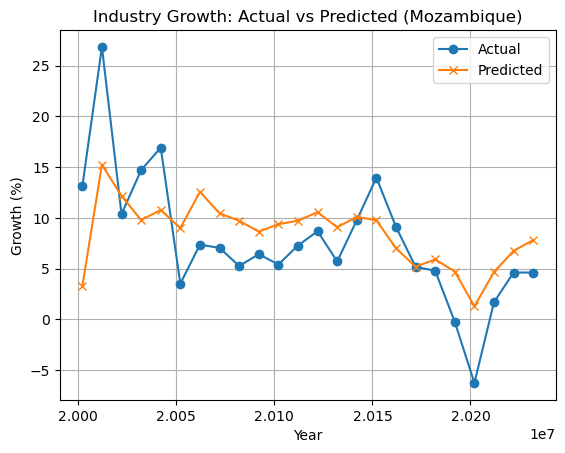

In [74]:
industry_low = prepare_panel_data(
    df=growth_rates_emissions_energy_prod_income_level_country_df,
    income_level='Low income',
    dependent_series="Industry (including construction), value added (annual % growth)"
)
print(f'Shape of panel data(target: Industry, income level: Low income):', industry_low.shape)
print(f'Columns of panel data(target: Industry, income level: Low income):', industry_low.columns)

results_industry_low = run_panel_regression_with_hausman(
    df_panel=industry_low,
    dependent_var="Industry (including construction), value added (annual % growth)"
)
# After fitting Random Effects model
y_pred = results_industry_low['re_results'].predict().fitted_values
industry_low = industry_low.reset_index()

# Add to original data to compare actual vs predicted
industry_low['actual'] = industry_low["Industry (including construction), value added (annual % growth)"]
industry_low['predicted'] = y_pred.values

sample_country = 'Mozambique'

df_sample = industry_low[industry_low['country'] == sample_country]

plt.plot(df_sample['year'], df_sample['actual'], label='Actual', marker='o')
plt.plot(df_sample['year'], df_sample['predicted'], label='Predicted', marker='x')
plt.title(f'Industry Growth: Actual vs Predicted ({sample_country})')
plt.xlabel('Year')
plt.ylabel('Growth (%)')
plt.legend()
plt.grid(True)
plt.show()

Shape of panel data(target: Industry, income level: Lower middle income): (1152, 10)
Columns of panel data(target: Industry, income level: Lower middle income): Index(['country', 'year', 'Access to electricity (% of population)',
       'Carbon dioxide (CO2) emissions excluding LULUCF per capita (t CO2e/capita)',
       'Energy intensity level of primary energy (MJ/$2017 PPP GDP)',
       'GDP growth (annual %)',
       'GDP per unit of energy use (PPP $ per kg of oil equivalent)',
       'Industry (including construction), value added (annual % growth)',
       'PM2.5 air pollution, mean annual exposure (micrograms per cubic meter)',
       'Renewable energy consumption (% of total final energy consumption)'],
      dtype='object')
--- Hausman Test ---
Statistic: -1.3257, p-value: 1.0000
Recommended model: Random Effects

--- Fixed Effects Results ---
                                                 PanelOLS Estimation Summary                                                  
Dep. Var

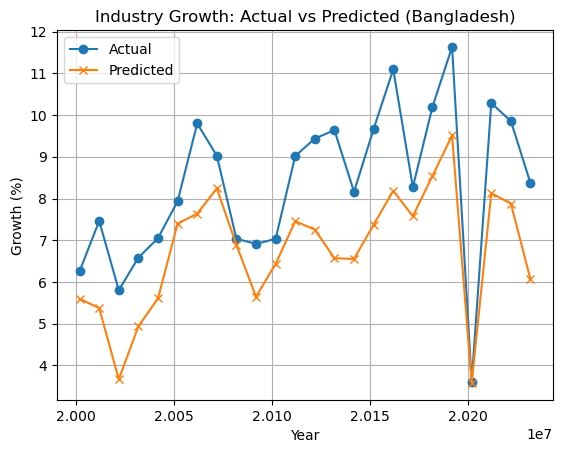

In [75]:
industry_lower_middle = prepare_panel_data(
    df=growth_rates_emissions_energy_prod_income_level_country_df,
    income_level='Lower middle income',
    dependent_series="Industry (including construction), value added (annual % growth)"
)
print(f'Shape of panel data(target: Industry, income level: Lower middle income):', industry_lower_middle.shape)
print(f'Columns of panel data(target: Industry, income level: Lower middle income):', industry_lower_middle.columns)
results_industry_lower_middle = run_panel_regression_with_hausman(
    df_panel=industry_lower_middle,
    dependent_var="Industry (including construction), value added (annual % growth)"
)
# After fitting Random Effects model
y_pred = results_industry_lower_middle['re_results'].predict().fitted_values
industry_lower_middle = industry_lower_middle.reset_index()

# Add to original data to compare actual vs predicted
industry_lower_middle['actual'] = industry_lower_middle["Industry (including construction), value added (annual % growth)"]
industry_lower_middle['predicted'] = y_pred.values

sample_country = 'Bangladesh'

df_sample = industry_lower_middle[industry_lower_middle['country'] == sample_country]

plt.plot(df_sample['year'], df_sample['actual'], label='Actual', marker='o')
plt.plot(df_sample['year'], df_sample['predicted'], label='Predicted', marker='x')
plt.title(f'Industry Growth: Actual vs Predicted ({sample_country})')
plt.xlabel('Year')
plt.ylabel('Growth (%)')
plt.legend()
plt.grid(True)
plt.show()

Shape of panel data(target: Industry, income level: Upper middle income): (1080, 10)
Columns of panel data(target: Industry, income level: Upper middle income): Index(['country', 'year', 'Access to electricity (% of population)',
       'Carbon dioxide (CO2) emissions excluding LULUCF per capita (t CO2e/capita)',
       'Energy intensity level of primary energy (MJ/$2017 PPP GDP)',
       'GDP growth (annual %)',
       'GDP per unit of energy use (PPP $ per kg of oil equivalent)',
       'Industry (including construction), value added (annual % growth)',
       'PM2.5 air pollution, mean annual exposure (micrograms per cubic meter)',
       'Renewable energy consumption (% of total final energy consumption)'],
      dtype='object')
--- Hausman Test ---
Statistic: 34.2539, p-value: 0.0000
Recommended model: Fixed Effects

--- Fixed Effects Results ---
                                                 PanelOLS Estimation Summary                                                  
Dep. Vari

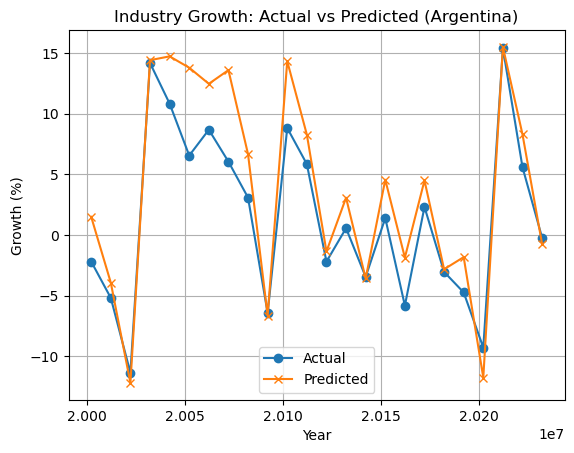

In [76]:
industry_upper_middle = prepare_panel_data(
    df=growth_rates_emissions_energy_prod_income_level_country_df,
    income_level='Upper middle income',
    dependent_series="Industry (including construction), value added (annual % growth)"
)
print(f'Shape of panel data(target: Industry, income level: Upper middle income):', industry_upper_middle.shape)
print(f'Columns of panel data(target: Industry, income level: Upper middle income):', industry_upper_middle.columns)
results_industry_Upper_middle = run_panel_regression_with_hausman(
    df_panel=industry_upper_middle,
    dependent_var="Industry (including construction), value added (annual % growth)"
)
# After fitting Random Effects model
y_pred = results_industry_Upper_middle['fe_results'].predict().fitted_values
industry_upper_middle = industry_upper_middle.reset_index()

# Add to original data to compare actual vs predicted
industry_upper_middle['actual'] = industry_upper_middle["Industry (including construction), value added (annual % growth)"]
industry_upper_middle['predicted'] = y_pred.values

sample_country = 'Argentina'

df_sample = industry_upper_middle[industry_upper_middle['country'] == sample_country]

plt.plot(df_sample['year'], df_sample['actual'], label='Actual', marker='o')
plt.plot(df_sample['year'], df_sample['predicted'], label='Predicted', marker='x')
plt.title(f'Industry Growth: Actual vs Predicted ({sample_country})')
plt.xlabel('Year')
plt.ylabel('Growth (%)')
plt.legend()
plt.grid(True)
plt.show()

### Services

Shape of panel data(target: Services, income level:  Low income): (240, 10)
Columns of panel data(target: Services, income level:  Low income): Index(['country', 'year', 'Access to electricity (% of population)',
       'Carbon dioxide (CO2) emissions excluding LULUCF per capita (t CO2e/capita)',
       'Energy intensity level of primary energy (MJ/$2017 PPP GDP)',
       'GDP growth (annual %)',
       'GDP per unit of energy use (PPP $ per kg of oil equivalent)',
       'PM2.5 air pollution, mean annual exposure (micrograms per cubic meter)',
       'Renewable energy consumption (% of total final energy consumption)',
       'Services, value added (annual % growth)'],
      dtype='object')
--- Hausman Test ---
Statistic: -33.2759, p-value: 1.0000
Recommended model: Random Effects

--- Fixed Effects Results ---
                                     PanelOLS Estimation Summary                                     
Dep. Variable:     Services, value added (annual % growth)   R-squared:   

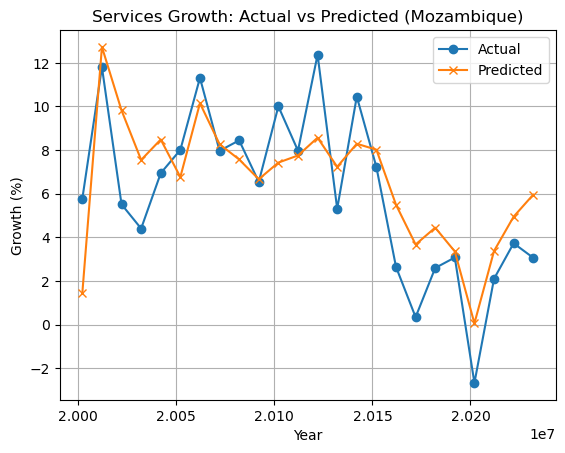

In [78]:
services_low = prepare_panel_data(
    df=growth_rates_emissions_energy_prod_income_level_country_df,
    income_level='Low income',
    dependent_series="Services, value added (annual % growth)"
)
print(f'Shape of panel data(target: Services, income level:  Low income):', services_low.shape)
print(f'Columns of panel data(target: Services, income level:  Low income):', services_low.columns)
results_services_low = run_panel_regression_with_hausman(
    df_panel=services_low,
    dependent_var="Services, value added (annual % growth)"
)
# After fitting Random Effects model
y_pred = results_services_low['re_results'].predict().fitted_values
services_low = services_low.reset_index()

# Add to original data to compare actual vs predicted
services_low['actual'] = services_low["Services, value added (annual % growth)"]
services_low['predicted'] = y_pred.values

sample_country = 'Mozambique'

df_sample = services_low[services_low['country'] == sample_country]

plt.plot(df_sample['year'], df_sample['actual'], label='Actual', marker='o')
plt.plot(df_sample['year'], df_sample['predicted'], label='Predicted', marker='x')
plt.title(f'Services Growth: Actual vs Predicted ({sample_country})')
plt.xlabel('Year')
plt.ylabel('Growth (%)')
plt.legend()
plt.grid(True)
plt.show()

Shape of panel data(target: Services, income level:  Lower middle income): (1152, 10)
Columns of panel data(target: Services, income level:  Lower middle income): Index(['country', 'year', 'Access to electricity (% of population)',
       'Carbon dioxide (CO2) emissions excluding LULUCF per capita (t CO2e/capita)',
       'Energy intensity level of primary energy (MJ/$2017 PPP GDP)',
       'GDP growth (annual %)',
       'GDP per unit of energy use (PPP $ per kg of oil equivalent)',
       'PM2.5 air pollution, mean annual exposure (micrograms per cubic meter)',
       'Renewable energy consumption (% of total final energy consumption)',
       'Services, value added (annual % growth)'],
      dtype='object')
--- Hausman Test ---
Statistic: 14.8897, p-value: 0.0613
Recommended model: Random Effects

--- Fixed Effects Results ---
                                     PanelOLS Estimation Summary                                     
Dep. Variable:     Services, value added (annual % growt

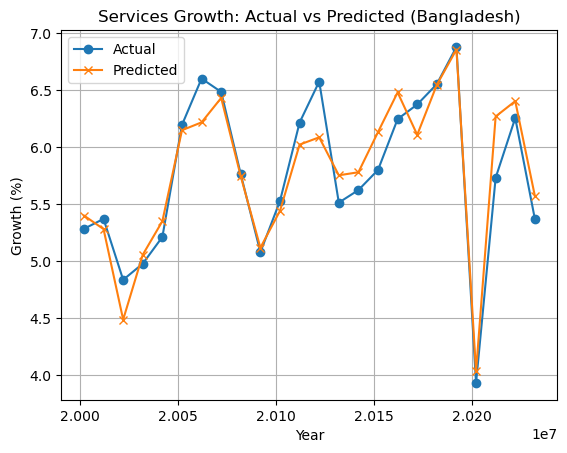

In [79]:
services_lower_middle = prepare_panel_data(
    df=growth_rates_emissions_energy_prod_income_level_country_df,
    income_level='Lower middle income',
    dependent_series="Services, value added (annual % growth)"
)
print(f'Shape of panel data(target: Services, income level:  Lower middle income):', services_lower_middle.shape)
print(f'Columns of panel data(target: Services, income level:  Lower middle income):', services_lower_middle.columns)
results_services_lower_middle = run_panel_regression_with_hausman(
    df_panel=services_lower_middle,
    dependent_var="Services, value added (annual % growth)"
)
# After fitting Random Effects model
y_pred = results_services_lower_middle['re_results'].predict().fitted_values
services_lower_middle = services_lower_middle.reset_index()

# Add to original data to compare actual vs predicted
services_lower_middle['actual'] = services_lower_middle["Services, value added (annual % growth)"]
services_lower_middle['predicted'] = y_pred.values

sample_country = 'Bangladesh'

df_sample = services_lower_middle[services_lower_middle['country'] == sample_country]

plt.plot(df_sample['year'], df_sample['actual'], label='Actual', marker='o')
plt.plot(df_sample['year'], df_sample['predicted'], label='Predicted', marker='x')
plt.title(f'Services Growth: Actual vs Predicted ({sample_country})')
plt.xlabel('Year')
plt.ylabel('Growth (%)')
plt.legend()
plt.grid(True)
plt.show()

Shape of panel data(target: Services, income level:  Upper middle income): (1080, 10)
Columns of panel data(target: Services, income level:  Upper middle income): Index(['country', 'year', 'Access to electricity (% of population)',
       'Carbon dioxide (CO2) emissions excluding LULUCF per capita (t CO2e/capita)',
       'Energy intensity level of primary energy (MJ/$2017 PPP GDP)',
       'GDP growth (annual %)',
       'GDP per unit of energy use (PPP $ per kg of oil equivalent)',
       'PM2.5 air pollution, mean annual exposure (micrograms per cubic meter)',
       'Renewable energy consumption (% of total final energy consumption)',
       'Services, value added (annual % growth)'],
      dtype='object')
--- Hausman Test ---
Statistic: -1.3472, p-value: 1.0000
Recommended model: Random Effects

--- Fixed Effects Results ---
                                     PanelOLS Estimation Summary                                     
Dep. Variable:     Services, value added (annual % growt

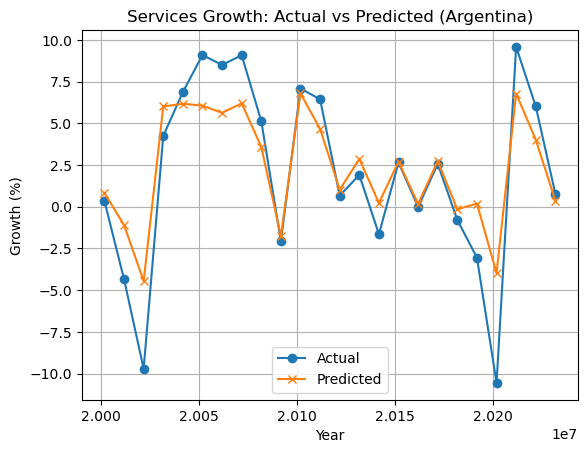

In [80]:
services_upper_middle = prepare_panel_data(
    df=growth_rates_emissions_energy_prod_income_level_country_df,
    income_level='Upper middle income',
    dependent_series="Services, value added (annual % growth)"
)
print(f'Shape of panel data(target: Services, income level:  Upper middle income):', services_upper_middle.shape)
print(f'Columns of panel data(target: Services, income level:  Upper middle income):', services_upper_middle.columns)
results_services_upper_middle = run_panel_regression_with_hausman(
    df_panel=services_upper_middle,
    dependent_var="Services, value added (annual % growth)"
)
# After fitting Random Effects model
y_pred = results_services_upper_middle['re_results'].predict().fitted_values
services_upper_middle = services_upper_middle.reset_index()

# Add to original data to compare actual vs predicted
services_upper_middle['actual'] = services_upper_middle["Services, value added (annual % growth)"]
services_upper_middle['predicted'] = y_pred.values

sample_country = 'Argentina'

df_sample = services_upper_middle[services_upper_middle['country'] == sample_country]

plt.plot(df_sample['year'], df_sample['actual'], label='Actual', marker='o')
plt.plot(df_sample['year'], df_sample['predicted'], label='Predicted', marker='x')
plt.title(f'Services Growth: Actual vs Predicted ({sample_country})')
plt.xlabel('Year')
plt.ylabel('Growth (%)')
plt.legend()
plt.grid(True)
plt.show()

### Applying PCA coordinates

In [82]:
# Load PCA coordinates of Low income countries

pca_coordinates_low = pd.read_csv("../datasets/pca_coordinates_low.csv", index_col=0)

print("Loaded countries in PCA:", pca_coordinates_low.index.tolist())
print(pca_coordinates_low.head())

# Load PCA coordinates of Lower middle income countries

pca_coordinates_lower_middle = pd.read_csv("../datasets/pca_coordinates_lower_middle.csv", index_col=0)

print("Loaded countries in PCA:", pca_coordinates_lower_middle.index.tolist())
print(pca_coordinates_lower_middle.head())

# Load PCA coordinates of Upper middle income countries
pca_coordinates_upper_middle = pd.read_csv("../datasets/pca_coordinates_upper.csv", index_col=0)

print("Loaded countries in PCA:", pca_coordinates_upper_middle.index.tolist())
print(pca_coordinates_upper_middle.head())

# Extract PCA-included low-income countries
pca_countries_low = set(pca_coordinates_low.index)

# Create a new dataframe with only PCA countries
growth_rates_pca_low_df = growth_rates_emissions_energy_prod_income_level_country_df[
    (growth_rates_emissions_energy_prod_income_level_country_df["Income Level"] == "Low income") &
    (growth_rates_emissions_energy_prod_income_level_country_df["Country Name"].isin(pca_countries_low))
].copy()

print("Shape of PCA-low dataframe:", growth_rates_pca_low_df.shape)
print("Included countries:\n", growth_rates_pca_low_df["Country Name"].unique())

# Extract PCA-included lower middle income countries
pca_countries_lower_middle = set(pca_coordinates_lower_middle.index)

# Create a new dataframe with only PCA countries
growth_rates_pca_lower_middle_df = growth_rates_emissions_energy_prod_income_level_country_df[
    (growth_rates_emissions_energy_prod_income_level_country_df["Income Level"] == "Lower middle income") &
    (growth_rates_emissions_energy_prod_income_level_country_df["Country Name"].isin(pca_countries_lower_middle))
].copy()

print("Shape of PCA-lower middle dataframe:", growth_rates_pca_lower_middle_df.shape)
print("Included countries:\n", growth_rates_pca_lower_middle_df["Country Name"].unique())

# Extract PCA-included Upper middle income countries
pca_countries_upper_middle = set(pca_coordinates_upper_middle.index)

# Create a new dataframe with only PCA countries
growth_rates_pca_upper_middle_df = growth_rates_emissions_energy_prod_income_level_country_df[
    (growth_rates_emissions_energy_prod_income_level_country_df["Income Level"] == "Upper middle income") &
    (growth_rates_emissions_energy_prod_income_level_country_df["Country Name"].isin(pca_countries_upper_middle))
].copy()

print("Shape of PCA-upper middle dataframe:", growth_rates_pca_upper_middle_df.shape)
print("Included countries:\n", growth_rates_pca_upper_middle_df["Country Name"].unique())

Loaded countries in PCA: ['Congo, Dem. Rep.', 'Ethiopia', 'Mozambique', 'Niger', 'Sudan', 'Togo', 'Zambia']
                       PC1       PC2
Country Name                        
Congo, Dem. Rep. -2.200238 -3.083218
Ethiopia         -2.904253  2.230247
Mozambique       -2.796460  1.548751
Niger             1.794707 -2.743065
Sudan             4.988857  1.795602
Loaded countries in PCA: ['Algeria', 'Angola', 'Bangladesh', 'Benin', 'Bolivia', 'Cambodia', 'Cameroon', 'Congo, Rep.', "Cote d'Ivoire", 'Egypt, Arab Rep.', 'El Salvador', 'Ghana', 'Haiti', 'Honduras', 'India', 'Indonesia', 'Iran, Islamic Rep.', 'Kenya', 'Kyrgyz Republic', 'Lebanon', 'Mongolia', 'Morocco', 'Myanmar', 'Nepal', 'Nicaragua', 'Nigeria', 'Pakistan', 'Philippines', 'Senegal', 'Sri Lanka', 'Tajikistan', 'Tanzania', 'Tunisia', 'Ukraine', 'Uzbekistan', 'Viet Nam', 'Zimbabwe']
                   PC1       PC2
Country Name                    
Algeria       2.448859  0.541382
Angola       -1.877612  0.351011
Bangladesh  

Shape of panel data(target: Industry, income level:  Lower middle income): (888, 10)
Columns of panel data(target: Industry, income level:  Lower middle income): Index(['country', 'year', 'Access to electricity (% of population)',
       'Carbon dioxide (CO2) emissions excluding LULUCF per capita (t CO2e/capita)',
       'Energy intensity level of primary energy (MJ/$2017 PPP GDP)',
       'GDP growth (annual %)',
       'GDP per unit of energy use (PPP $ per kg of oil equivalent)',
       'Industry (including construction), value added (annual % growth)',
       'PM2.5 air pollution, mean annual exposure (micrograms per cubic meter)',
       'Renewable energy consumption (% of total final energy consumption)'],
      dtype='object')
--- Hausman Test ---
Statistic: 8.8535, p-value: 0.3548
Recommended model: Random Effects

--- Fixed Effects Results ---
                                                 PanelOLS Estimation Summary                                                  
Dep. Var

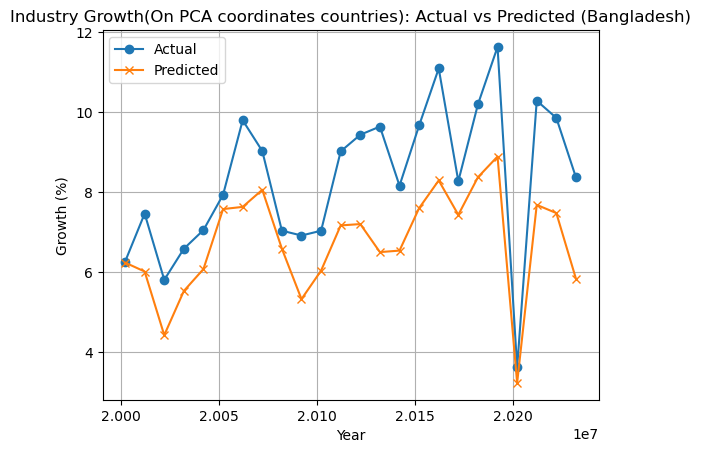

In [83]:
# Applying on Lower middle income level for industry sector
industry_lower_middle_pca = prepare_panel_data(
    df=growth_rates_pca_lower_middle_df,
    income_level='Lower middle income',
    dependent_series="Industry (including construction), value added (annual % growth)"
)
print(f'Shape of panel data(target: Industry, income level:  Lower middle income):', industry_lower_middle_pca.shape)
print(f'Columns of panel data(target: Industry, income level:  Lower middle income):', industry_lower_middle_pca.columns)
results_industry_lower_middle_pca = run_panel_regression_with_hausman(
    df_panel=industry_lower_middle_pca,
    dependent_var="Industry (including construction), value added (annual % growth)"
)
# After fitting Random Effects model
y_pred = results_industry_lower_middle_pca['re_results'].predict().fitted_values
industry_lower_middle_pca = industry_lower_middle_pca.reset_index()

# Add to original data to compare actual vs predicted
industry_lower_middle_pca['actual'] = industry_lower_middle_pca["Industry (including construction), value added (annual % growth)"]
industry_lower_middle_pca['predicted'] = y_pred.values

sample_country = 'Bangladesh'

df_sample = industry_lower_middle_pca[industry_lower_middle_pca['country'] == sample_country]

plt.plot(df_sample['year'], df_sample['actual'], label='Actual', marker='o')
plt.plot(df_sample['year'], df_sample['predicted'], label='Predicted', marker='x')
plt.title(f'Industry Growth(On PCA coordinates countries): Actual vs Predicted ({sample_country})')
plt.xlabel('Year')
plt.ylabel('Growth (%)')
plt.legend()
plt.grid(True)
plt.show()

In [84]:
# Extract PCA-included lower middle income countries
pca_countries_lower_middle = set(pca_coordinates_lower_middle.index)

growth_rates_pca_lower_middle_df_excluded = growth_rates_emissions_energy_prod_income_level_country_df[
    (growth_rates_emissions_energy_prod_income_level_country_df["Income Level"] == "Lower middle income") &
    (~growth_rates_emissions_energy_prod_income_level_country_df["Country Name"].isin(pca_countries_lower_middle))
].copy()

print("Shape of PCA-excluded-lower middle dataframe:", growth_rates_pca_lower_middle_df_excluded.shape)
print("Excluded countries:\n", growth_rates_pca_lower_middle_df_excluded["Country Name"].unique())

Shape of PCA-excluded-lower middle dataframe: (1138, 41)
Excluded countries:
 ['Bhutan' 'Cabo Verde' 'Comoros' 'Djibouti' 'Eswatini' 'Kiribati'
 'Lao PDR' 'Lesotho' 'Mauritania' 'Micronesia, Fed. Sts.'
 'Papua New Guinea' 'Samoa' 'Sao Tome and Principe' 'Solomon Islands'
 'Timor-Leste' 'Vanuatu' 'West Bank and Gaza']


#### Training on PCA included countries vs prediction on excluded country(Bhutan)

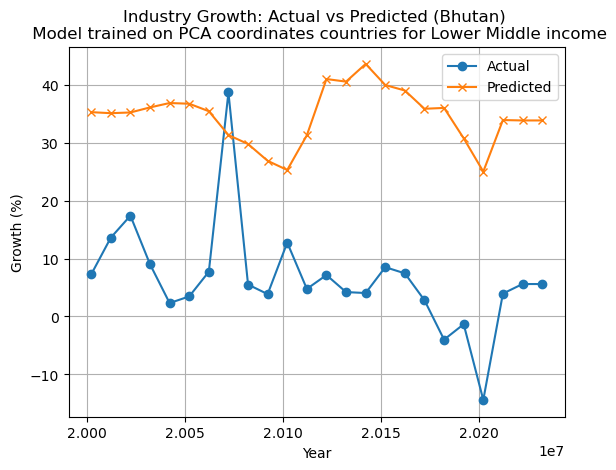

In [86]:
# Extract Bhutan's data
X_bhutan = industry_lower_middle[
    industry_lower_middle['country'] == 'Bhutan'
].copy()

# Use the same features used during training
cols_to_exclude = ['country', 'year', 'Industry (including construction), value added (annual % growth)', 'actual', 'predicted']
exog_vars = [col for col in industry_lower_middle_pca.columns if col not in cols_to_exclude]

# Create design matrix and set proper MultiIndex
X_bhutan_exog = X_bhutan.set_index(['country', 'year'])[exog_vars]
X_bhutan_exog = add_constant(X_bhutan_exog, has_constant='add')

# Predict using the Random Effects model
bhutan_pred = results_industry_lower_middle_pca['re_results'].predict(exog=X_bhutan_exog)

# Flatten MultiIndex and prepare plot
X_bhutan.reset_index(drop=True, inplace=True)
X_bhutan['predicted'] = bhutan_pred.values
X_bhutan['actual'] = X_bhutan["Industry (including construction), value added (annual % growth)"]

# Plot actual vs predicted
plt.plot(X_bhutan['year'], X_bhutan['actual'], label='Actual', marker='o')
plt.plot(X_bhutan['year'], X_bhutan['predicted'], label='Predicted', marker='x')
plt.title('Industry Growth: Actual vs Predicted (Bhutan) \n Model trained on PCA coordinates countries for Lower Middle income')
plt.xlabel('Year')
plt.ylabel('Growth (%)')
plt.legend()
plt.grid(True)
plt.show()


#### Training on ALL countries vs prediction on Bhutan

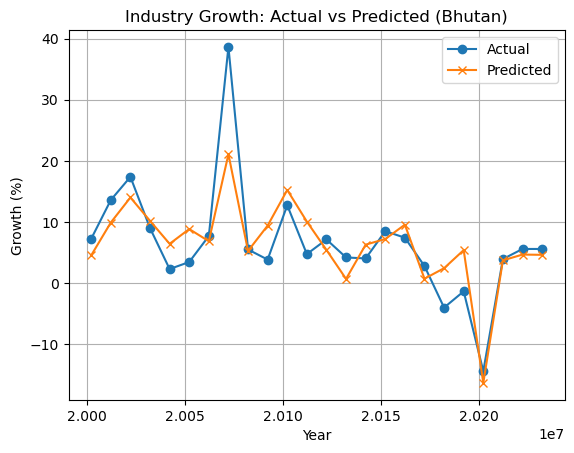

In [88]:

sample_country = 'Bhutan'

df_sample = industry_lower_middle[industry_lower_middle['country'] == sample_country]

plt.plot(df_sample['year'], df_sample['actual'], label='Actual', marker='o')
plt.plot(df_sample['year'], df_sample['predicted'], label='Predicted', marker='x')
plt.title(f'Industry Growth: Actual vs Predicted ({sample_country})')
plt.xlabel('Year')
plt.ylabel('Growth (%)')
plt.legend()
plt.grid(True)
plt.show()

In [89]:
# Multicollinearity Check

In [90]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

df_to_check = agri_df_upper_middle.copy()

cols_to_exclude = ['country', 'year', 'Industry (including construction), value added (annual % growth)', 'actual', 'predicted']
exog_vars = [col for col in df_to_check.columns if col not in cols_to_exclude]

X = add_constant(df_to_check[exog_vars])

vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_data


,feature,VIF
0,const,125.149401
1,Access to electricity (% of population),1.108743
2,"Agriculture, forestry, and fishing, value adde...",1.044836
3,Carbon dioxide (CO2) emissions excluding LULUC...,1.722284
4,Energy intensity level of primary energy (MJ/$...,1.917321
5,GDP growth (annual %),1.056800
6,GDP per unit of energy use (PPP $ per kg of oi...,2.167276
7,"PM2.5 air pollution, mean annual exposure (mic...",1.051648
8,Renewable energy consumption (% of total final...,1.236561


Variance Inflation Factor (VIF) was used to detect multicollinearity among independent variables in the agriculture model for upper middle income countries. All predictor variables have VIF values below 5, indicating that multicollinearity is not a concern in this model. Therefore, all selected variables were retained for regression analysis without adjustment.

In [92]:
# Create interaction term between REC and GDPgrowth
agri_df_upper_middle['REC_GDPgrowth'] = (
    agri_df_upper_middle['Renewable energy consumption (% of total final energy consumption)'] *
    agri_df_upper_middle['GDP growth (annual %)']
)


In [93]:
agri_df_interaction = agri_df_upper_middle.copy()

results_agri_interaction = run_panel_regression_with_hausman(
    df_panel=agri_df_interaction,
    dependent_var='Agriculture, forestry, and fishing, value added (annual % growth)'
)

--- Hausman Test ---
Statistic: 6.6203, p-value: 0.6766
Recommended model: Random Effects

--- Fixed Effects Results ---
                                                  PanelOLS Estimation Summary                                                  
Dep. Variable:     Agriculture, forestry, and fishing, value added (annual % growth)   R-squared:                        0.0404
Estimator:                                                                  PanelOLS   R-squared (Between):             -1.2003
No. Observations:                                                               1080   R-squared (Within):               0.0349
Date:                                                               Wed, May 07 2025   R-squared (Overall):             -0.0007
Time:                                                                       15:03:29   Log-likelihood                   -3987.9
Cov. Estimator:                                                               Robust                           